In [ ]:
!pip install icecream
!pip install bubbly

Libraries

In [24]:
import csv
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from icecream import ic
from matplotlib import rc
from random import shuffle
from IPython.display import HTML
from bubbly.bubbly import bubbleplot 
from plotly.offline import init_notebook_mode, iplot

Initial Conditions

In [25]:
total_population = 200 # Total Population of people 
percent_masked = 50 # Percentage of people wearing masks
population_density = 30 # Percent of capacity of places filled by people
num_of_generations = 80 # Number of days to run the simulation
with_mask_prob_infect = 0.10 # probability of getting infected with people weating masks
without_mask_prob_infect = 0.90 # probability of getting infected without anyone wearing a mask

change_vaccination_rate_on = False
change_lockdown_on = False
# testing_on = False
# testing_number = 12
lockdown_intensity = 3.0
vaccinate_percent = 0.0 # percent of people to vaccinated everyday
incubation_period = 14 # How many days does the virus live
fatality = 2 # What percent of population dies on acquiring the disease

d = { # Contains values for probabilities of catching the virus based on how many people are wearing masks
    'mm': 0.01, # Both wearing masks
    'mn': 0.1, # One wearing mask
    'nm': 0.1, # One wearing mask
    'nn': 0.9 # Nobody wearing a mask
}

##Running the Simulation

In [26]:
persons = [] # list of human (person) objects
masks = [] # list of masked objects
maskless = [] # list of unmasked objects
places = [] # list of place objects
persons2 = [] # list of quarantined people

count_quarantined = [] # Counts current number of quarantined people
num_mask = round((percent_masked*total_population)/100) # Starting number of mask objects
num_maskless = total_population - num_mask # Starting number of maskless objects
num_place = round(total_population/(population_density*0.05)) # Number of different places people can be at GIVEN MAX PEOPLE IN ONE PLACE IS 5

vaccinate_frequency = round((vaccinate_percent*total_population))/100 # number of people to vaccinated everyday
# mask_prob_infect = with_mask_prob_infect

total_mask_infected = 0
total_maskless_infected = 0
cumulative_infected = 0
total_vaccinated_people = 0

In [27]:
# Functions used later
def less_than_num_prob(probability):
  """returns True, with the probability of returning True equal to the parameter, returns False otherwise"""
  return random.randint(1, 100) <= probability

def pinv(num):
  """returns 1 - num as long as parameter is between 0 and 1"""
  if num >= 0.0 and num <= 1.0:
    return 1 - num

In [28]:
## CREATING LOCATION CLASS
class Place:
  def __init__(self, value, person1, person2, person3, person4, person5):
    self.value = value # How many additional people this place can occupy
    self.person1 = person1 # Type of person on place object
    self.person2 = person2 # Type of person on place object
    self.person3 = person3 # Type of person on place object
    self.person4 = person4 # Type of person on place object
    self.person5 = person5 # Type of person on place object

  def get_value():
    print(self.value)

In [29]:
## CREATE LOCATION OBJECTS
for i in range(num_place):
  places.append(Place(5.0, None, None, None, None, None))

In [30]:
def all_place_occupied():
  """Checks if all place objects have been completely occupied by persons"""
  temp = True
  for place in places:
    if None in [place.person1, place.person2, place.person3, place.person4, place.person5]:
      temp = False
  return temp


def all_people_vaccinated():
  """Checks if all people have been vaccinated"""
  temp = True
  for person in persons:
    if not person.is_vaccinated:
      temp = False
  return temp

In [31]:
## CREATE BLOB CLASSES
class Person:
  def __init__(self, place_num, place_received, protection_rate, is_infected, is_vaccinated):
    self.place_num = place_num
    self.place_received = place_received
    self.protection_rate = protection_rate
    self.is_infected = is_infected
    self.is_vaccinated = is_vaccinated

  def assign_place(self):
    """Assigns available place object to the person. Person remains unassigned if all place objects are occupied"""
    person_assigned = False
    while person_assigned == False and not all_place_occupied():
      x = random.randint(0, len(places) - 1)
      if not places[x].value == 0:
        self.place_num = x
        person_assigned = True
        setattr(places[x], 'person' + str(int(6 - (places[x].value))), self)
        places[x].value -= 1.0

  def person_die(self):
    """Has a probability of 2% of killing infected people"""
    if self.is_infected and less_than_num_prob(fatality):
      persons.remove(self)

class Mask(Person):
  pass

class Maskless(Person):
  pass

In [32]:
## CREATE People OBJECTS
for i in range(num_mask):
  persons.append(Mask(0, -1.0, with_mask_prob_infect, False, False))
for i in range(num_maskless):
  persons.append(Maskless(0, -1.0, 1, False, False))

shuffle(persons)
for person in persons: #Assigns a place to each person
  person.assign_place()


THE FIRST COVID POSITIVE PEOPLE

In [33]:
for i in range(10):
  persons[i].is_infected = True
  persons[i].days_left = 14

  if isinstance(persons[i], Mask):
    total_mask_infected += 1
    persons[i].protection_rate = with_mask_prob_infect
  else:
    total_maskless_infected += 1
    persons[i].protection_rate = without_mask_prob_infect

In [34]:
def get_prob(list1):
  result = 1
  for l in list1:
    result *= pinv(d[l])
  return round(pinv(result), 3)

In [35]:
def sick_countdown():
  """Manages recovery from disease after a particular number of days"""
  for person in persons:
    if person.is_infected:
      person.days_left -= 1
      if person.days_left == 0:
        person.is_infected = False
        person.is_vaccinated = True

def transmit_disease():
  """Distributes disease viruses at each generation"""

  global total_mask_infected
  global total_maskless_infected

  for place in places:
    temp = True
    place_persons = [place.person1, place.person2, place.person3, place.person4, place.person5]
    if lockdown_intensity is not 0:
      del(place_persons[:int(lockdown_intensity)])
    for i in place_persons:
      if i is None:
        temp = False
    infected = []
    non_infected = []
    mask_rates = 1
    if temp:
      for i in place_persons:
        if i.is_infected:
          infected.append(i)
        else:
          non_infected.append(i)

  ###################
    # Calculating probabilities of people getting infected
    for i in non_infected:
      values = []
      if isinstance(i, Mask):
        value1 = 'm'
      else:
        value1 = 'n'
      for j in infected:
        if isinstance(j, Mask):
          value2 = 'm'
        else:
          value2 = 'n'
        values.append(value1+value2) # Creates list with 'mm', 'mn' values. Putting in get_prob function return probability

      if less_than_num_prob(get_prob(values) * 100) and not i.is_vaccinated:
        i.is_infected = True
        if isinstance(i, Mask):
          total_mask_infected += 1
        elif isinstance(i, Maskless):
          total_maskless_infected += 1
        i.days_left = incubation_period


def vaccinate_people():
  """Vaccinates 'vaccinate_frequency' number of people every day"""
  global total_vaccinated_people
  num = len(persons)
  i = 0
  j = 0
  while i < vaccinate_frequency and not all_people_vaccinated() and j < total_population:
    x = random.randint(0, num - 1)
    if persons[x].is_vaccinated or persons[x].is_infected:
      i -= 1
    else:
      persons[x].is_vaccinated = True
      total_vaccinated_people += 1
    i += 1
    j += 1

In [36]:
def reset_values():
  for place in places: # Resetting place object values for next iteration
    place.value = 5.0 - lockdown_intensity
    place.person1 = None
    place.person2 = None
    place.person3 = None
    place.person4 = None
    place.person5 = None
  for person in persons: # Resetting person object values for next iteration
    person.place_num = 0
    person.place_received = -1.0
    person.assign_place()

def count_masks():
  count = 0
  for person in persons:
    if isinstance(person, Mask):
      count += 1
  return count

def count_maskless():
  count = 0
  for person in persons:
    if isinstance(person, Maskless):
      count += 1
  return count

def count_infected_people():
  """Counts the number of infected people"""
  num_infected = 0
  for person in persons:
    if person.is_infected:
      num_infected += 1
  return num_infected


def count_infected_people_by_mask():
  mask_infect = 0
  for person in persons:
    if person.is_infected and isinstance(person, Mask):
      mask_infect += 1
  return mask_infect

def count_infected_people_by_maskless():
  maskless_infect = 0
  for person in persons:
    if person.is_infected and isinstance(person, Maskless):
      maskless_infect += 1
  return maskless_infect

def count_cumulative_infected():
  global cumulative_infected
  for person in persons:
    if person.is_infected and person.days_left == 14:
      cumulative_infected += 1

**Main Block**

In [37]:
total_num_infected = []
vaccinations = []
mask_infected = []
maskless_infected = []
dead_masked_people = []
dead_maskless_people = []
cumulative_infected_list = []
pop_vs_generation = {} # Dictionary containing generation number and number of persons alive



ic.disable()
for i in range(num_of_generations): # Each iteration is one generation
  ic("generation", i+1)
  for place in places:
    ic(place.person1, place.person2, place.person3, place.person4, place.person5)

  transmit_disease()
  count_cumulative_infected()
  sick_countdown()
  

  cumulative_infected_list.append(cumulative_infected)
  vaccinate_people()
  vaccinations.append(total_vaccinated_people)

  for person in persons:
    person.person_die()

  dead_masked_people.append(num_mask - count_masks())
  dead_maskless_people.append(num_maskless - count_maskless())
  infected_people = count_infected_people()
  total_num_infected.append(infected_people)
  mask_infected.append(count_infected_people_by_mask())
  maskless_infected.append(count_infected_people_by_maskless())
  count_quarantined.append(len(persons2))


  pop_vs_generation[i+1] = infected_people


  reset_values()
  ic("Generation", i+1, "over")
  ic('\n\n')
  if change_lockdown_on:
    if infected_people/total_population >= 0.20:
      lockdown_intensity = 0.0
    elif infected_people/total_population < 0.2 and infected_people/total_population >= 0.1:
      lockdown_intensity = 2.0
    elif infected_people/total_population < 0.1:
      lockdown_intensity = 3.0
  if change_vaccination_rate_on:
    if i == 15:
      vaccinate_percent = 0.4
      vaccinate_frequency = round((vaccinate_percent*total_population))/100

# END

##Plotting Graphs

### Tweak the initial conditions at the top of the code and see how the graph changes

A total of 137 people were infected in this run
Total masked people who got infected is 37
Total maskless people who got infected is 100
Total number of people vaccinated is 0


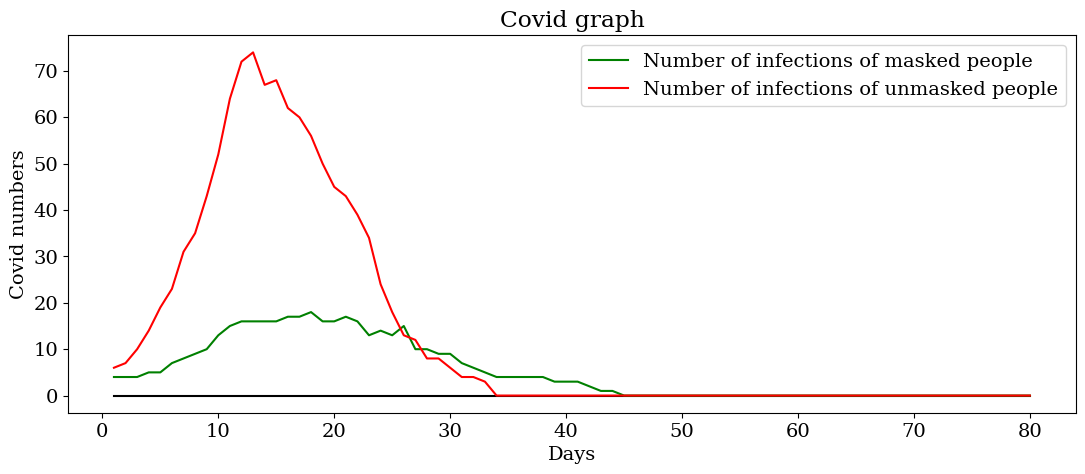

In [38]:
# import matplotlib.pyplot as plt
print("A total of", total_mask_infected+total_maskless_infected, 'people were infected in this run')
print("Total masked people who got infected is", total_mask_infected)
print("Total maskless people who got infected is", total_maskless_infected)
print('Total number of people vaccinated is', total_vaccinated_people)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'serif'})
w = 13
h = 5
d = 100
plt.figure(figsize=(w, h), dpi=d)
x1, y1, y2, y, x = [], [], [], [], []
for i in range(num_of_generations):
  x1.append(i+1)
  y1.append(0)
y2 = total_num_infected[:]
y3 = mask_infected[:]
y4 = maskless_infected[:]

plt.plot(x1, y1, color = 'black')
plt.plot(x1, y3, color = 'green', label = "Number of infections of masked people")
plt.plot(x1, y4, color = 'red', label = "Number of infections of unmasked people")

plt.legend();
plt.title("Covid graph");
plt.xlabel("Days");
plt.ylabel("Covid numbers");

##Graphs

###Masks

All graphs below have been generated from simulation data of previous runs with the starting population as 10,000 people.

In [39]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', '50% Masked', '75% Masked'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', height = 600, range_y = [0, 10300])

fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days')

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')

figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'City A: No Masks'
  fig.data[1].name = 'City C: 75% Masked'
  fig.data[2].name = 'City B: 50% Masked'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)
fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [40]:
fig1.show()

In [41]:
fig2.show()

In [42]:
fig3.show()

####Deaths

In [43]:
fdata2 = data1['Conditions'].isin(['50% Masked'])
new = data1[fdata2]
x=new['Day']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, y=new['dead_masked_people'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(5, 250, 5)'),
    name='Masked People Deaths',
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=new['dead_maskless_people'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(220, 2, 1)'),
    name='Unmasked People Deaths',
    stackgroup='one'
))

fig.update_layout(yaxis_range=(0, max(new['dead_maskless_people']) + 600), xaxis_range=(0, 65),
                  title = 'Deaths vs Days for City B', xaxis_title='Days', yaxis_title='Number of deaths', font_family="Times New Roman",
  font_size=20)
fig.show()

‏‏‎ ‎

In [44]:
fdata2 = data1['Conditions'].isin(['No measures', '50% Masked', '75% Masked'])
new = data1[fdata2]
x=new['Day']

fig = px.area(new, x='Day', y='total_dead', color='Conditions', labels={'total_dead':'Number of Deaths'})

fig.update_layout(
font_family="Times New Roman",
font_size=20,
title='Deaths comparison for Cities A, B, and C'
)

fig.data[0].name = 'City A: No Masks'
fig.data[1].name = 'City C: 75% Masked'
fig.data[2].name = 'City B: 50% Masked'

fig.show()

‏‏‎ ‎

‏‏‎ ‎

‏‏‎ ‎

‏‏‎ ‎

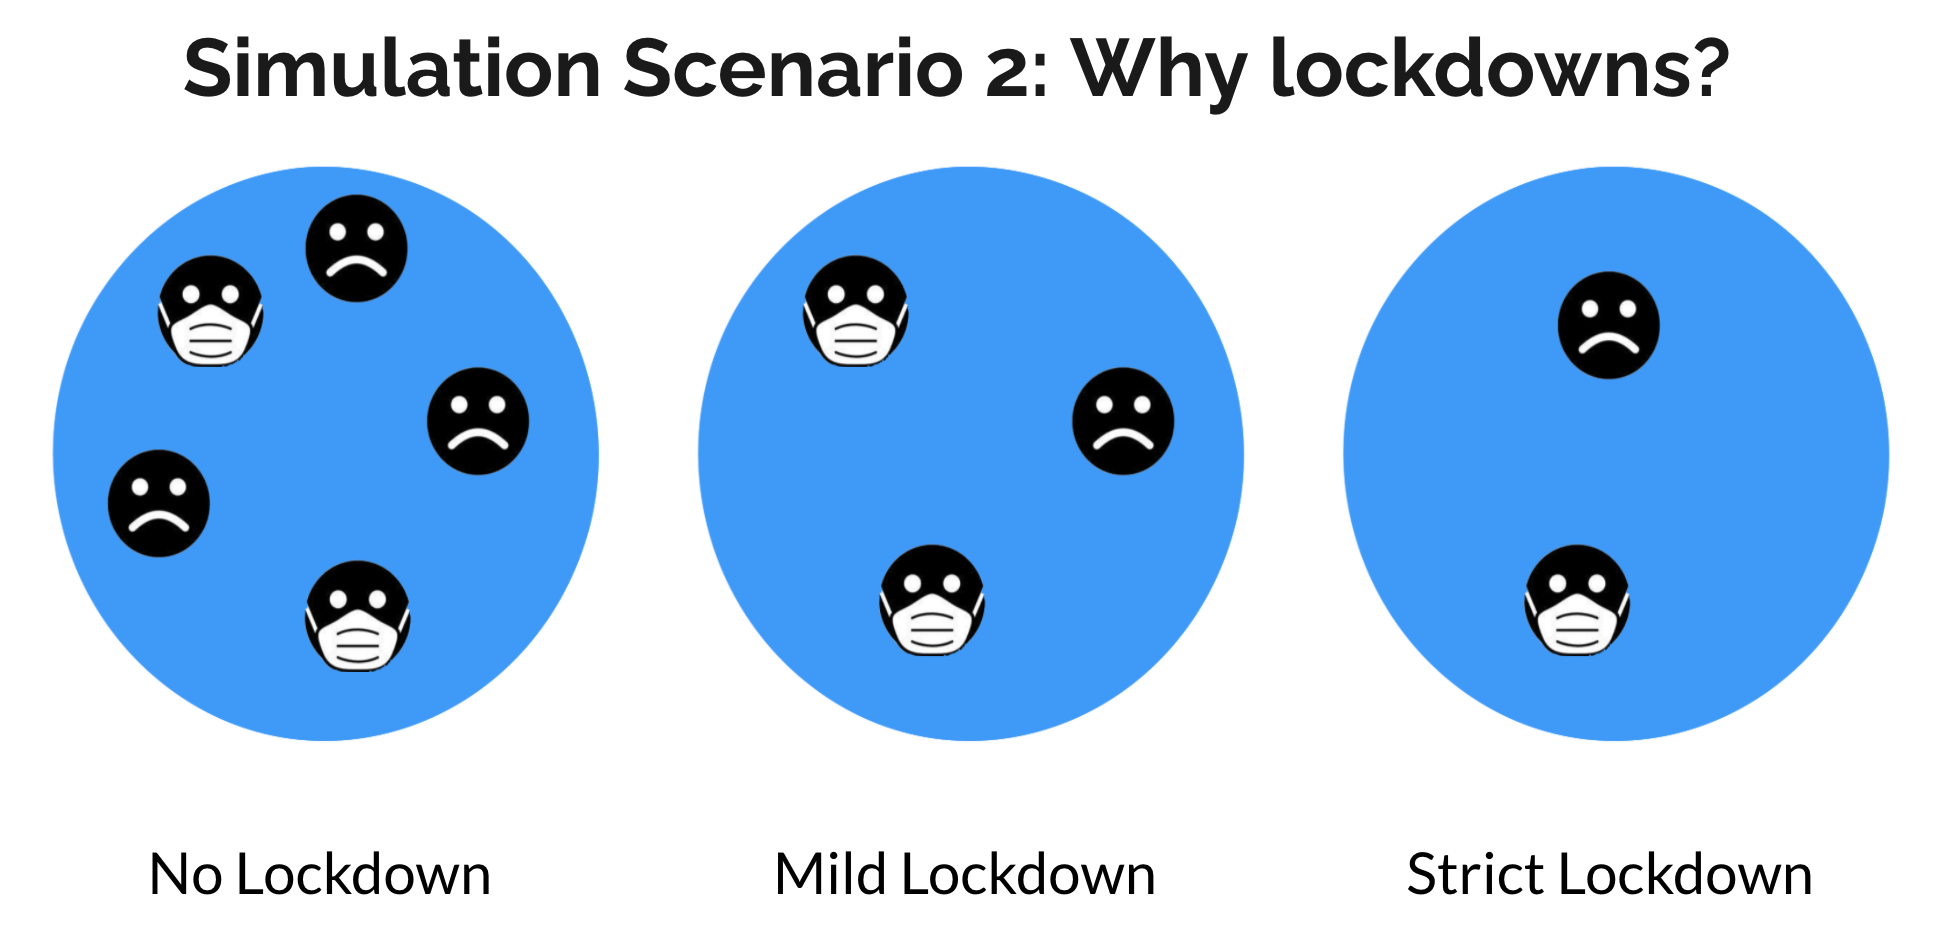

‏‏‎ ‎

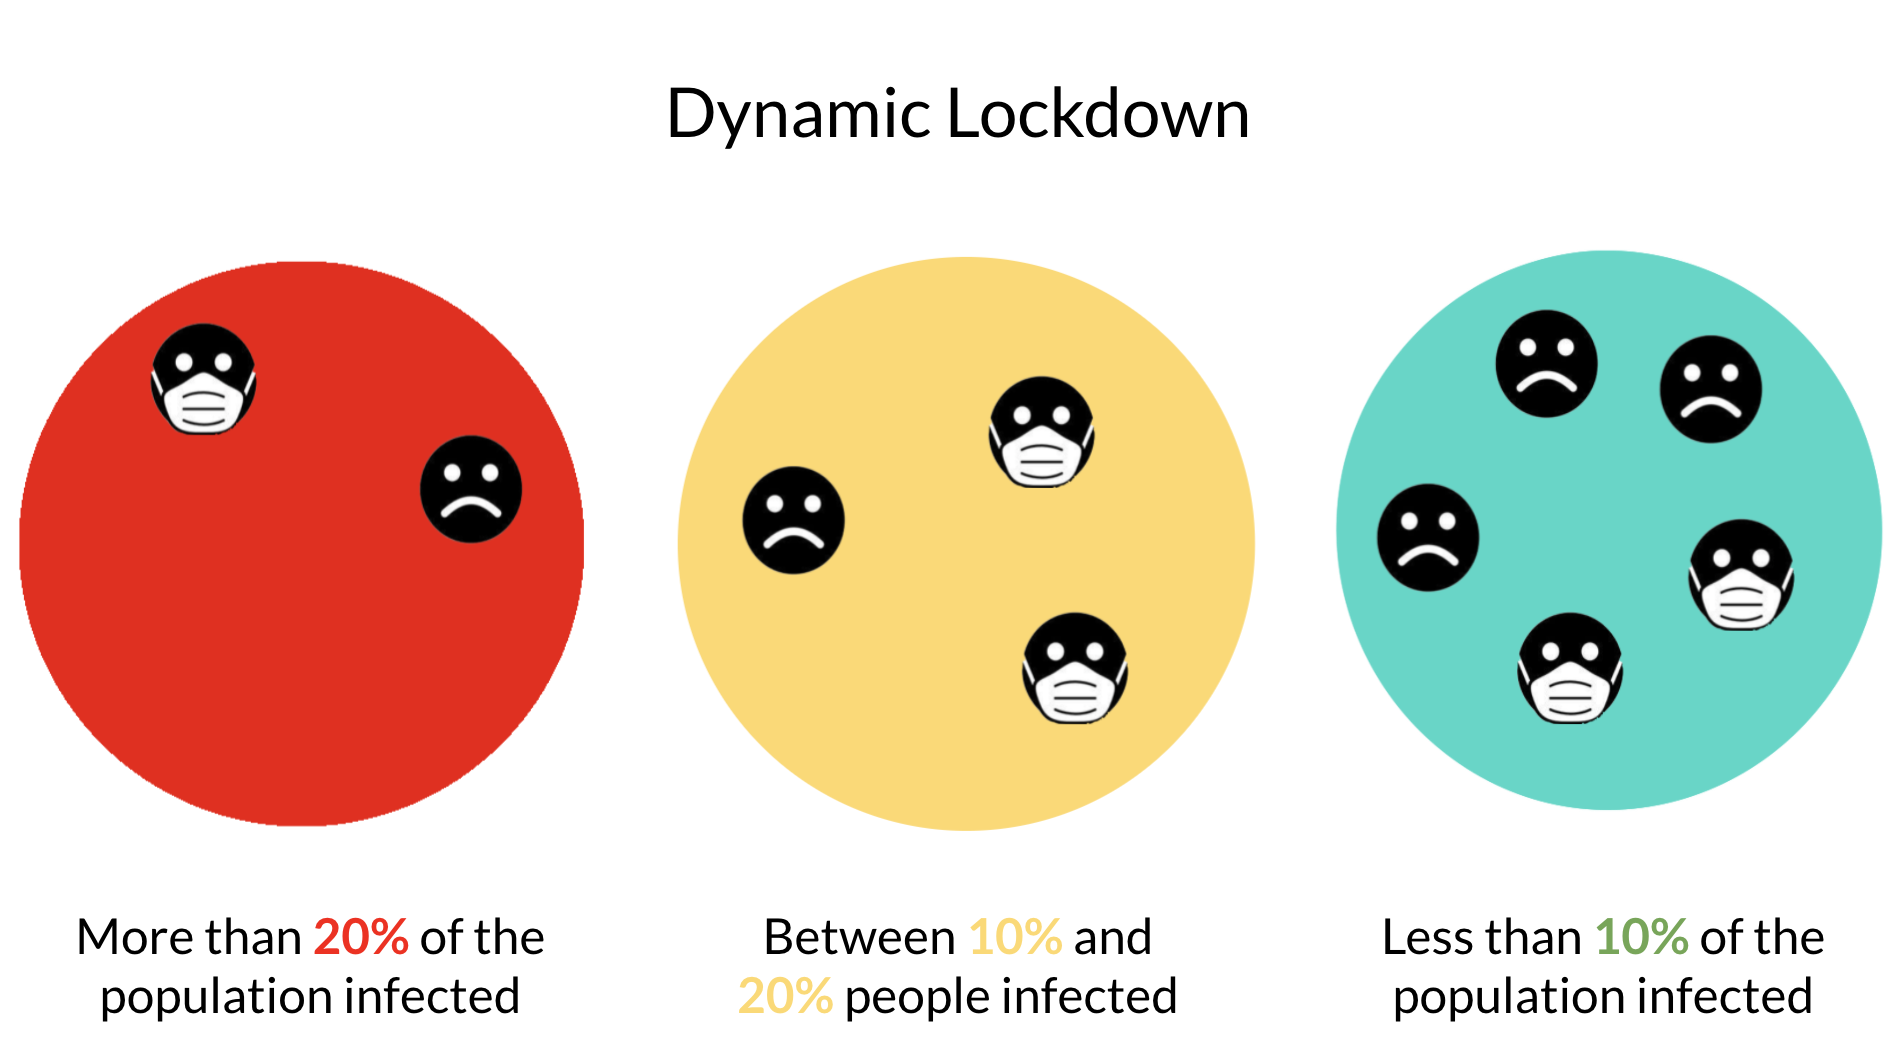

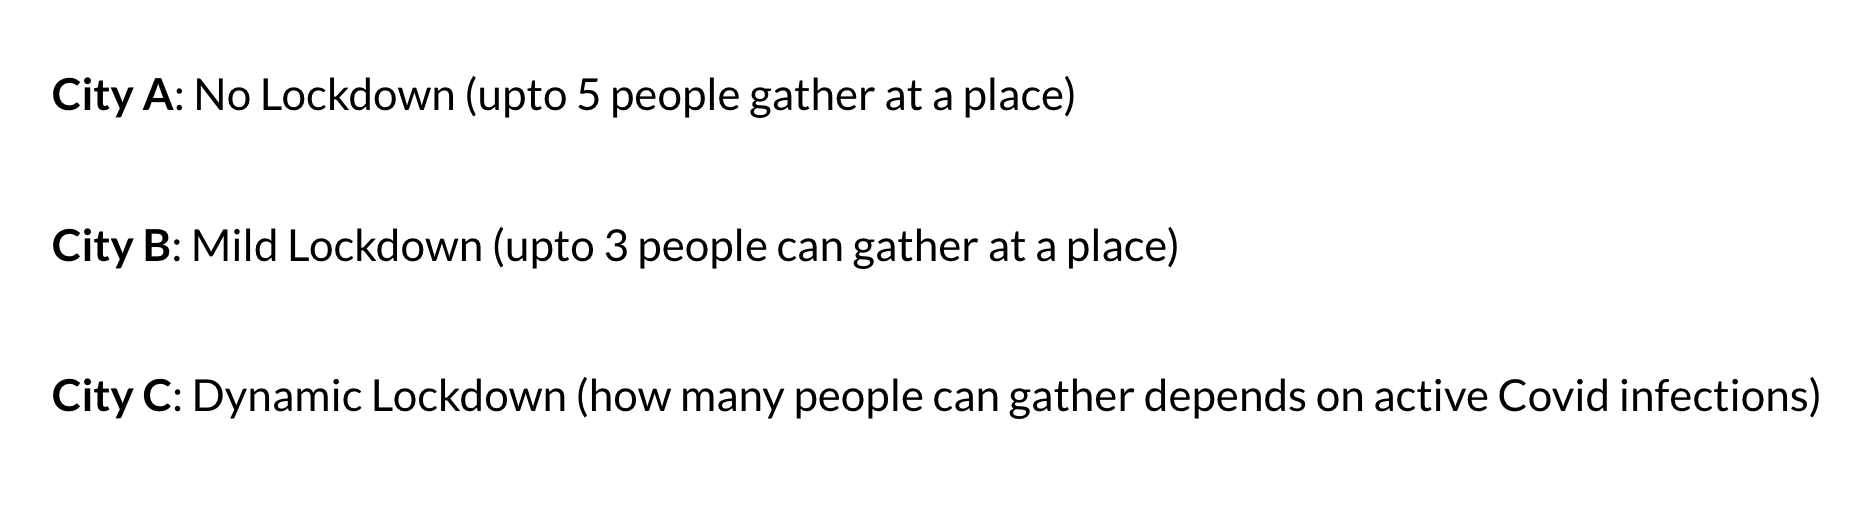

‎

‏‏‎ ‎

In [45]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', 'Only Mild Lockdown', 'Dynamic Lockdown'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', range_y = [0, 10300])

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')
fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Cumulative Cases'}, 
                  title = 'Cumulative Cases vs Days')
figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'City A: No Lockdowns'
  fig.data[1].name = 'City C: Dynamic Lockdowns'
  fig.data[2].name = 'City B: Continuous Mild Lowckdown'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)


fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [46]:
fig1.show()

In [47]:
fig2.show()

In [48]:
fig3.show()

‏‏‎ ‎

‎

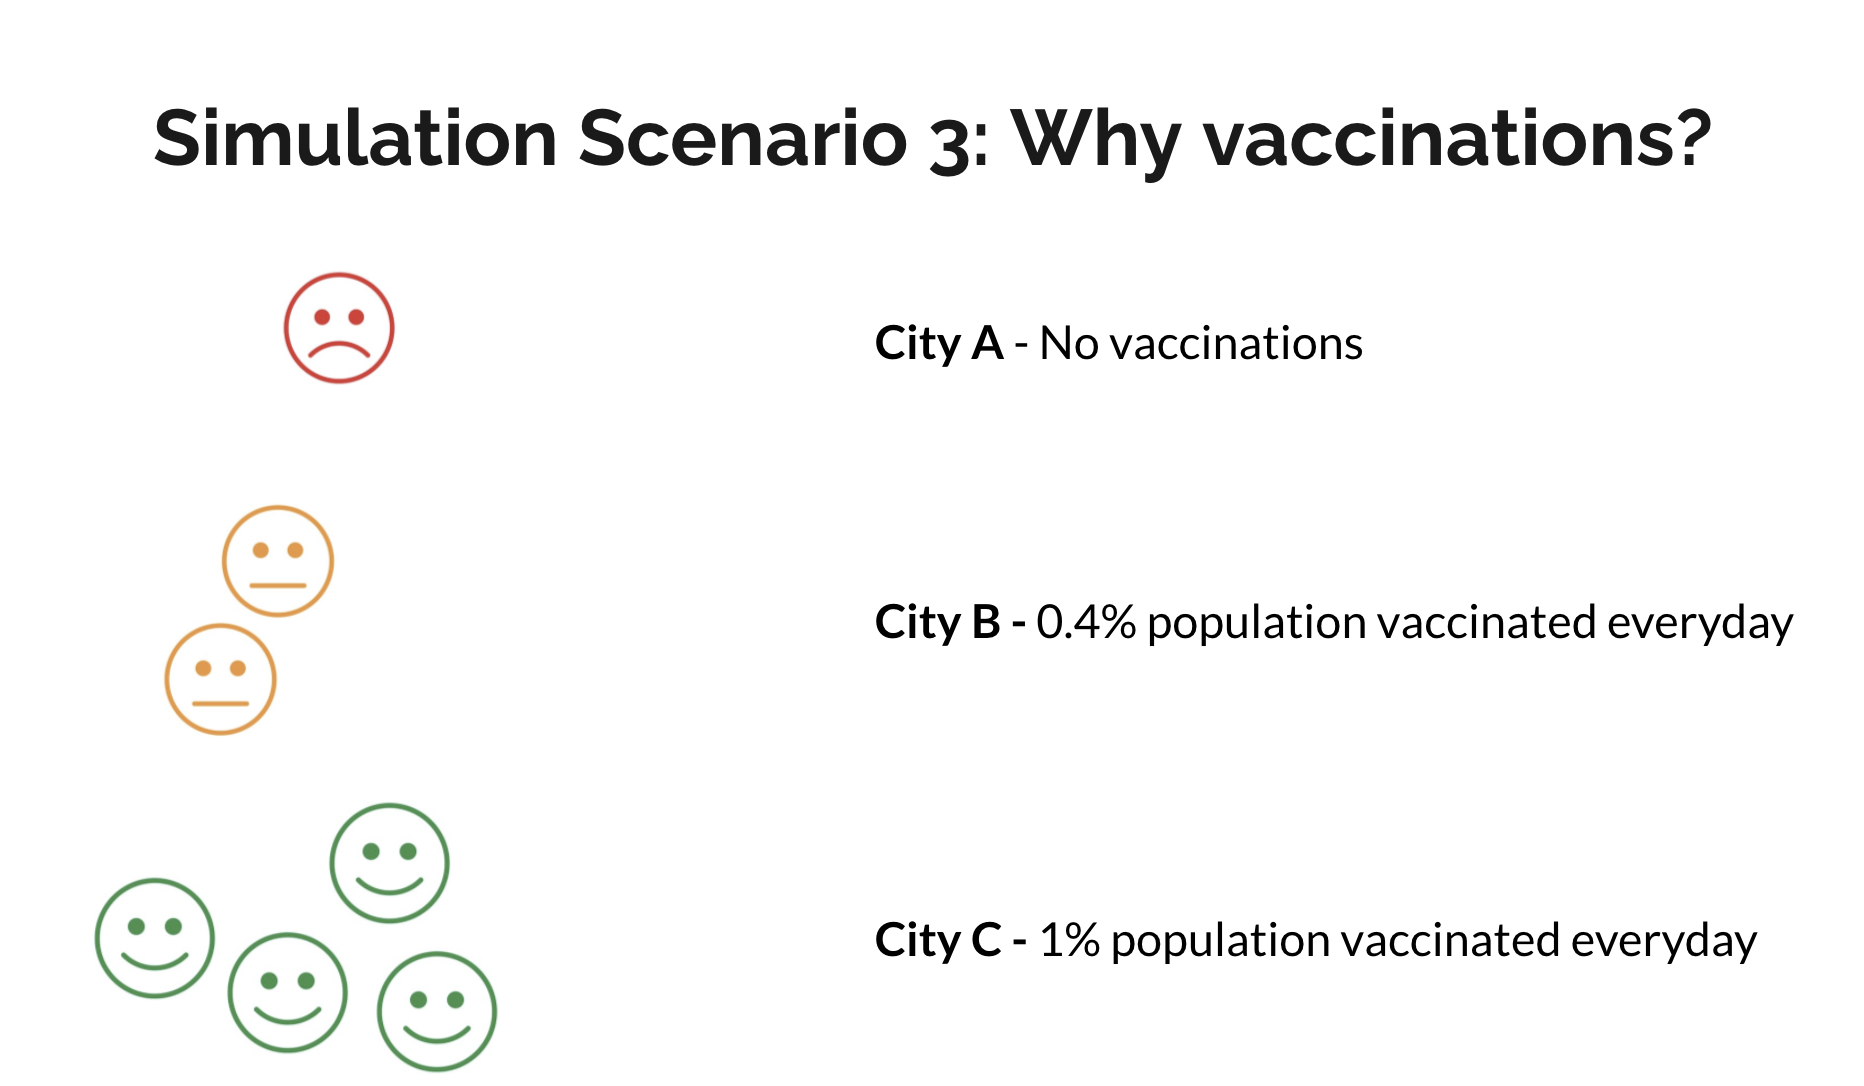

‏‏‎ ‎

In [49]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', '0.4% vax rate', '1% vax rate'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', range_y = [0, 10300])

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')
fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number infected'}, 
                  title = 'Active Cases vs Days')
figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'City A: No Vaccinations'
  fig.data[2].name = 'City B: 0.4% Vaccinations'
  fig.data[1].name = 'City C: 1% Vaccinations'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)


fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [50]:
fig1.show()

In [51]:
fig2.show()

In [52]:
fig3.show()

In [53]:
fig4 = px.line(data1[fdata1], x='Day', y='total_dead', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_dead': 'Number of people dead'}, 
                  title = 'Deaths vs Days')
fig4.update_layout(
  font_family="Times New Roman",
  font_size=20,
)
fig4.show()

‎‎‎‎‎‏‏‎ ‎


# NLP

# Natural Language Processing

In [54]:
def get_range(num):
    '''Gives the range of a given sentiment score'''
    if num < -0.1:
        return 'Negative'
    elif num >= -0.1 and num < 0.1:
        return 'Neutral'
    elif num >= 0.1:
        return 'Positive'

content = [] # Is the list of all tweets
with open('mask_tweets.json') as file:
    for line in file:
        list.append(str(line))

    for l in list:
        x = json.loads(l)
        content.append(x['content'])

with open('tweet_ranges.csv', 'w') as f: #
    f.write('Sentiments')
    f.write('\n')
    for c in content:
        score = sid.polarity_scores(c)['compound']
        f.write(get_range(score))
        f.write('\n')

FileNotFoundError: ignored

‎

# Natural Language Processing (NLP)

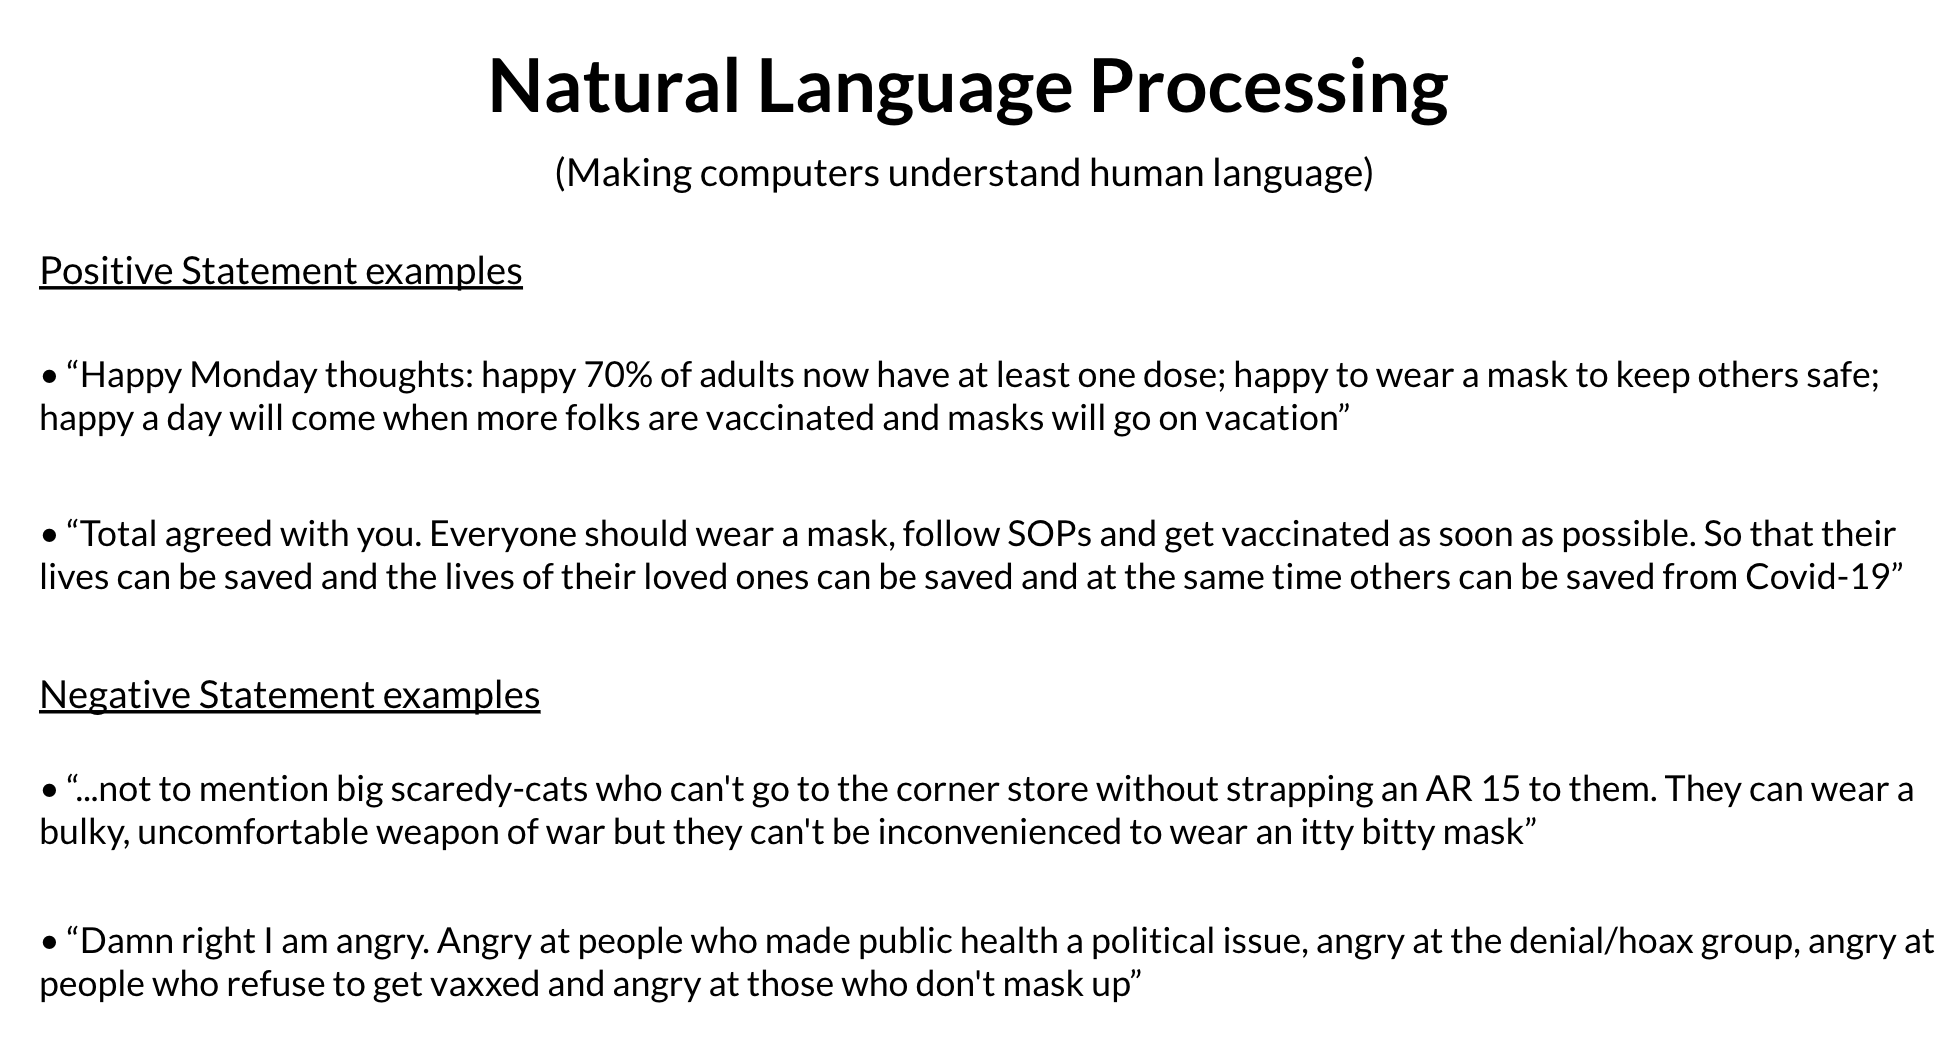

In [ ]:
df = pd.read_csv('tweet_ranges.csv')
fig = px.pie(df, names = 'Sentiments', title = 'Sentiment scores for tweets about masks', hole=0.3)
fig.update_layout(
  font_family="Times New Roman",
  font_size=23,
)
fig.show()

‎

‏‏‎ ‎

# All measures bubble plot‎

In [ ]:
path = '/content/animation_data.csv'

In [ ]:
figure = bubbleplot(dataset = pd.read_csv('/content/animation_data.csv'), x_column='total_dead', y_column='cumulative_infected_list', 
    bubble_column='Day', size_column='total_dead', time_column = 'Day', color_column='Conditions', 
    x_title="Deaths", y_title="Number of infections", title='Covid simulation',
    x_logscale=False, scale_bubble=2, height=650);

figure['layout']['sliders'][0]['currentvalue']['prefix'] = 'Day:'

In [ ]:
# print(figure)

‎

In [ ]:
iplot(figure);

‏‏‎ ‎

In [ ]:
# data=pd.read_csv('animation_data.csv')

# # Set the figure size
# plt.figure(figsize=(10, 10))

# # Scatterplot
# plt.scatter(
#     x = data['Day'], 
#     y = data['cumulative_infected_list'], 
#     s=data1952['pop']/50000, 
#     c=data1952['continent'].cat.codes, 
#     cmap="Accent", 
#     alpha=0.6, 
#     edgecolors="white", 
#     linewidth=2);
 
# # Add titles (main and on axis)
# plt.xlabel("Life Expectancy")
# plt.ylabel("GDP per Capita")
# plt.title("Year 1952")
# plt.ylim(0,50000)
# plt.xlim(30, 75);



# figure = bubbleplot(dataset = pd.read_csv('/content/animation_data.csv'), x_column='total_dead', y_column='cumulative_infected_list', 
#     bubble_column='Day', size_column='total_dead', time_column = 'Day', color_column='Conditions', 
#     x_title="Deaths", y_title="Number of infections", title='Covid simulation',
#     x_logscale=False, scale_bubble=2, height=650);

# iplot(figure);